# Compiling Datasets, Data Inspection and Data reduction

This notebook is to make sure anyone can produce the **exactly** same datasets used in the paper

Please see http://astronn.readthedocs.io/en/latest/quick_start.html#folder-structure-for-astronn-apogee-and-gaia-data
to setup the enviroment such that astroNN can download SDSS APOGEE data to your computer and compile the dataset

In [1]:
from astroNN.datasets import H5Compiler
from astroNN.apogee import allstar
from astropy.io import fits
import numpy as np

# To create a astroNN compiler instance
compiler = H5Compiler()
compiler.teff_low = 4000  # Effective Temperature Upper
compiler.teff_high = 5500  # Effective Temperature Lower
compiler.vscattercut = 1  # Velocity Scattering Upper
compiler.starflagcut = True  # STARFLAG == 0
compiler.aspcapflagcut = True  # ASPCAPFALG == 0
compiler.ironlow = -10000.  # [Fe/H] Lower
compiler.SNR_low = 200  # SNR Lower
compiler.SNR_high = 99999  # SNR Upper

# allstar file
hdulist = fits.open(allstar(dr=14))

# idx refers to the indices in allstar(dr=14)
idx = compiler.filter_apogeeid_list(hdulist)

compiler.filename = '__train'

# To compile a .h5 datasets, use .compile() method
compiler.compile()

C:\Users\Henry\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


E:\sdss_mirror\dr14/apogee/spectro/redux/r8/stars/l31c/l31c.2/allStar-l31c.2.fits was found!
Total Combined Spectra after filtering:  33407
Total Individual Visit Spectra there:  98596
dr is not provided, using default dr=14
E:\sdss_mirror\dr14/apogee/spectro/redux/r8/stars/l31c/l31c.2/allStar-l31c.2.fits was found!
Loading allStar DR14 catalog
Total Combined Spectra after filtering:  33407
Total Individual Visit Spectra there:  98596
Completed 1 of 33407, 0.25s elapsed
Completed 101 of 33407, 2.09s elapsed
Completed 201 of 33407, 3.91s elapsed
Completed 301 of 33407, 5.80s elapsed
Completed 401 of 33407, 7.84s elapsed
Completed 501 of 33407, 9.86s elapsed
Completed 601 of 33407, 11.88s elapsed
Completed 701 of 33407, 13.92s elapsed
Completed 801 of 33407, 15.95s elapsed
Completed 901 of 33407, 17.98s elapsed
Completed 1001 of 33407, 20.01s elapsed
Completed 1101 of 33407, 22.06s elapsed
Completed 1201 of 33407, 24.05s elapsed
Completed 1301 of 33407, 25.95s elapsed
Completed 1401 of 3

In [1]:
from astroNN.datasets import H5Compiler
compiler = H5Compiler()
compiler.filename = '_highsnr_test'

# This is for a high SNR Test Set
compiler.teff_low = 4000  # Effective Temperature Upper
compiler.teff_high = 5500  # Effective Temperature Lower
compiler.vscattercut = 1  # Velocity Scattering Upper
compiler.starflagcut = True  # STARFLAG == 0
compiler.aspcapflagcut = True  # ASPCAPFALG == 0
compiler.ironlow = -10000.  # [Fe/H] Lower
compiler.SNR_low = 100
compiler.SNR_high = 200

compiler.compile()

dr is not provided, using default dr=14
E:\sdss_mirror\dr14/apogee/spectro/redux/r8/stars/l31c/l31c.2/allStar-l31c.2.fits was found!
Loading allStar DR14 catalog
Total Combined Spectra after filtering:  28692
Total Individual Visit Spectra there:  86200
Completed 1 of 28692, 0.42s elapsed
Completed 101 of 28692, 5.99s elapsed
Completed 201 of 28692, 8.56s elapsed
Completed 301 of 28692, 10.90s elapsed
Completed 401 of 28692, 13.32s elapsed
Completed 501 of 28692, 15.85s elapsed
Completed 601 of 28692, 18.25s elapsed
Completed 701 of 28692, 21.12s elapsed
Completed 801 of 28692, 23.67s elapsed
Completed 901 of 28692, 26.30s elapsed
Completed 1001 of 28692, 28.55s elapsed
Completed 1101 of 28692, 30.80s elapsed
Completed 1201 of 28692, 32.68s elapsed
Completed 1301 of 28692, 34.70s elapsed
Completed 1401 of 28692, 36.81s elapsed
Completed 1501 of 28692, 39.13s elapsed
Completed 1601 of 28692, 41.46s elapsed
Completed 1701 of 28692, 43.48s elapsed
Completed 1801 of 28692, 45.31s elapsed
C

## Training and Testing Set SNR Disturbution

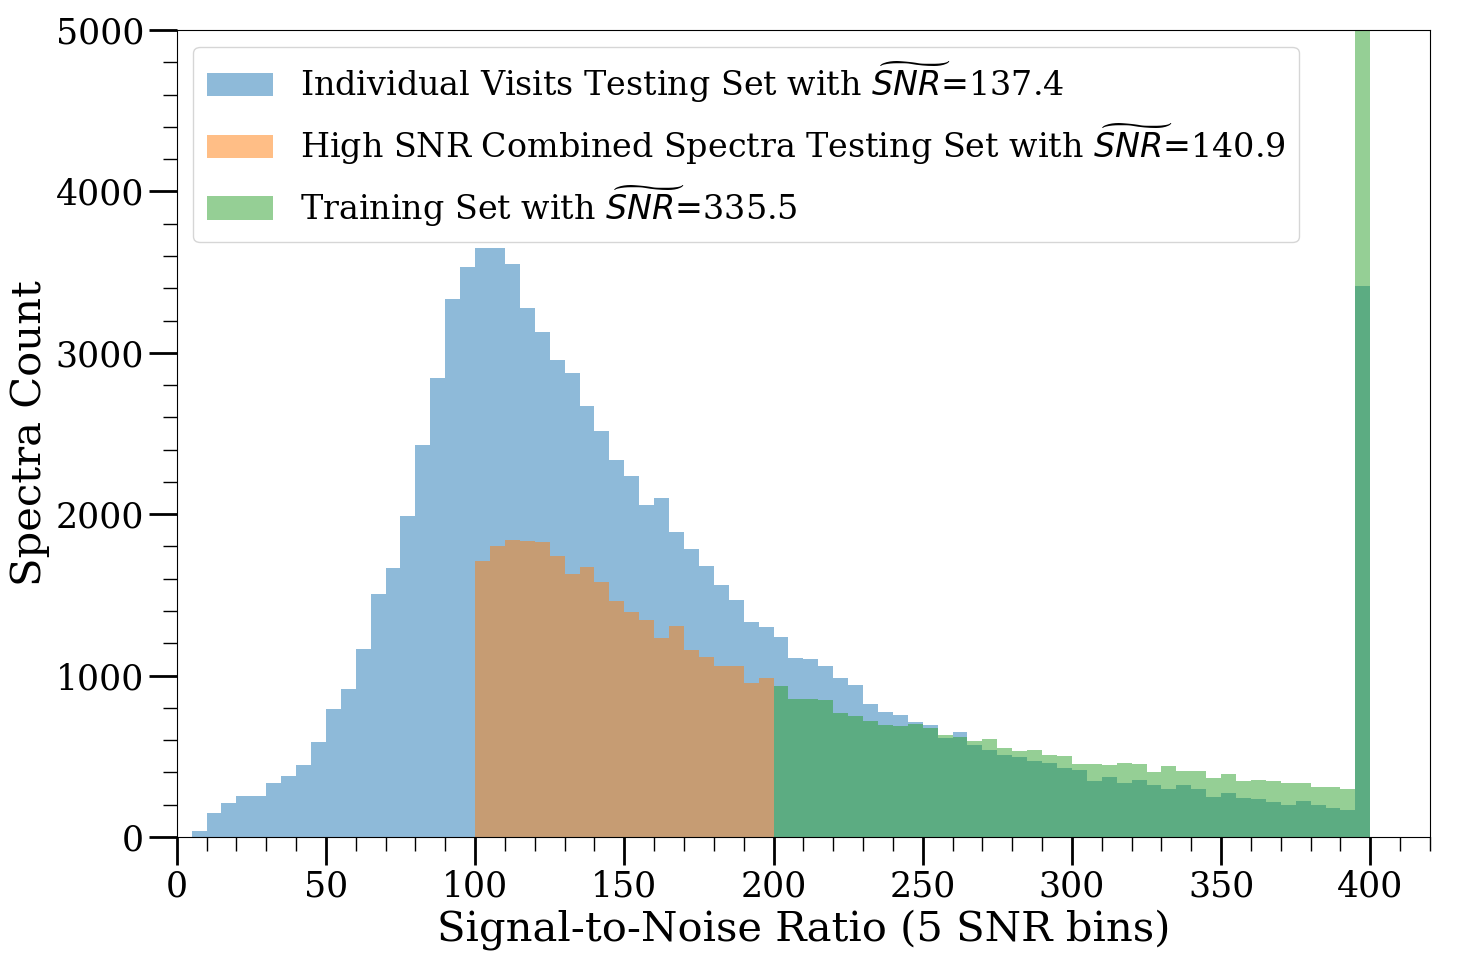

In [2]:
%matplotlib inline
from astroNN.datasets import H5Loader
import pylab as plt
import numpy as np

plt.rc('font',**{'family': 'serif', 'weight':'medium', 'size':20})
loader = H5Loader('__train')
loader.load_err = False
loader.load_combined = True  # load combined spectra
SNR_train = loader.load_entry('SNR')

loader2 = H5Loader('__train')
loader2.load_err = False
loader2.load_combined = False
SNR_test = loader2.load_entry('SNR')

loader3 = H5Loader('_highsnr_test')
loader3.load_err = False
loader3.load_combined = True
SNR_test_highsnr = loader3.load_entry('SNR')

upper_bound = 400  # if SNR higher than 400, count it as  400

SNR_test_plot = np.array(SNR_test)
SNR_train_plot = np.array(SNR_train)
SNR_test_highsnr_plot = np.array(SNR_test_highsnr)
SNR_test_plot[(SNR_test>upper_bound)] = upper_bound
SNR_train_plot[(SNR_train>upper_bound)] = upper_bound

plt.figure(figsize=(15,10), dpi=100)
plt.hist(SNR_test_plot, 80, range=(0, 400), alpha=0.5, label='Individual Visits Testing Set with $\widetilde{SNR}$=' + f'{np.median(SNR_test):.{1}f}')
plt.hist(SNR_test_highsnr_plot, 20, range=(100, 200), alpha=0.5, label='High SNR Combined Spectra Testing Set with $\widetilde{SNR}$=' + f'{np.median(SNR_test_highsnr):.{1}f}')
plt.hist(SNR_train_plot, 40, range=(200, 400), alpha=0.5, label='Training Set with $\widetilde{SNR}$=' + f'{np.median(SNR_train):.{1}f}')
plt.xlabel('Signal-to-Noise Ratio (5 SNR bins)', fontsize=30)
plt.ylabel('Spectra Count', fontsize=30)
plt.ylim((0, 5000))
plt.xlim((0))
plt.legend(loc='best', fontsize=24)
plt.minorticks_on()
plt.tick_params(labelsize=25, width=2, length=20, which='major')
plt.tick_params(width=1, length=10, which='minor')
plt.tight_layout()
plt.savefig('SNR.pdf')
plt.show()

This is the training set
995  of the log(g) are -9999.


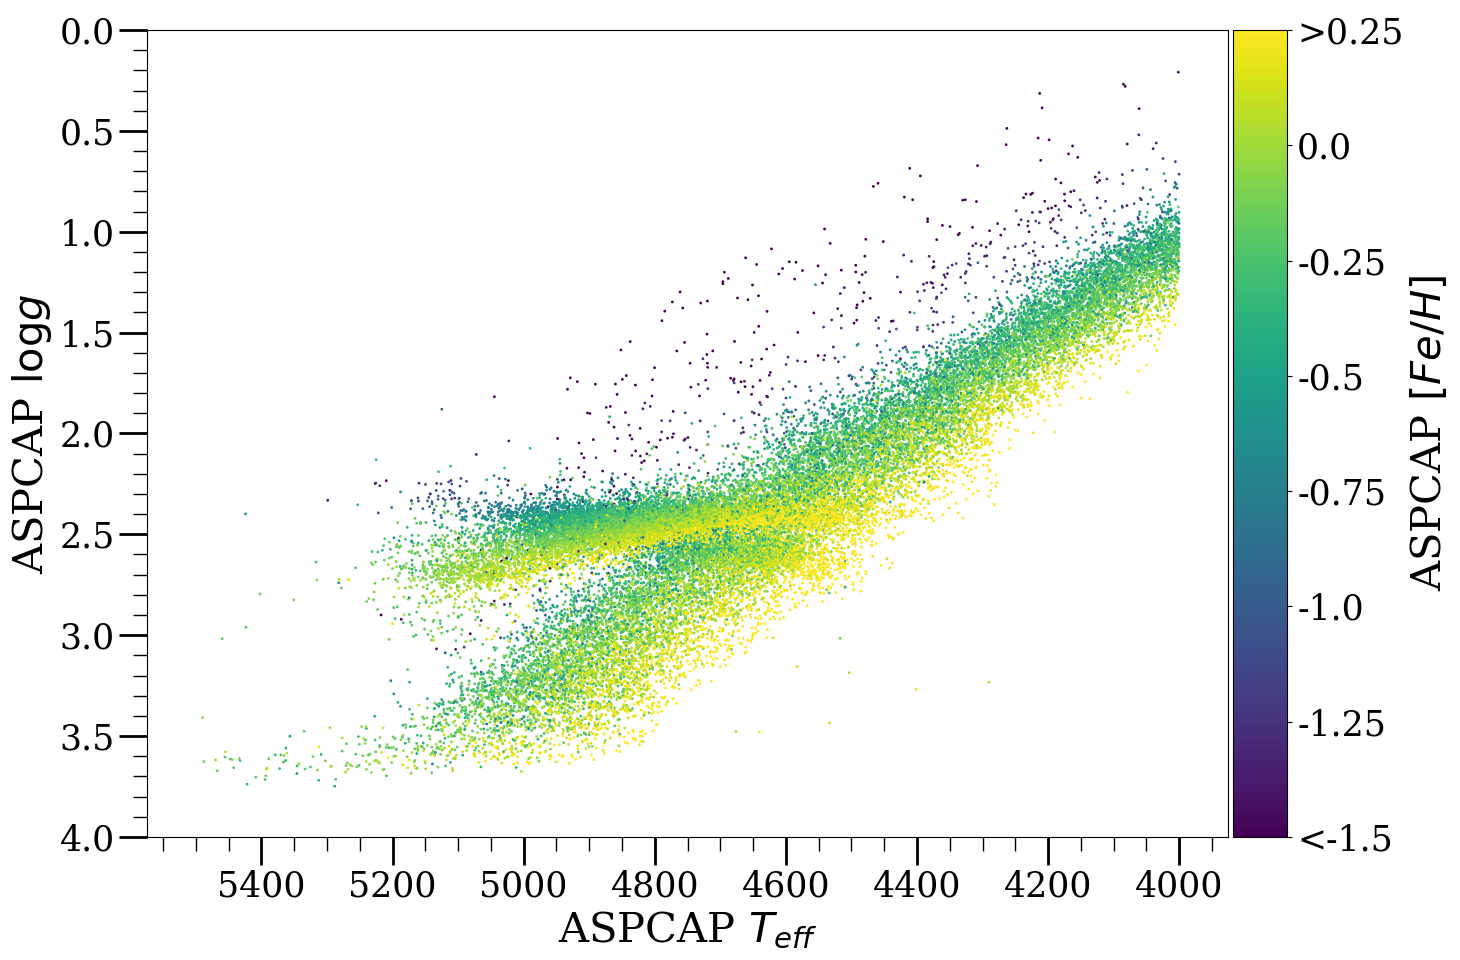

In [4]:
%matplotlib inline
from astroNN.datasets import H5Loader
import pylab as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rc('font',**{'family': 'serif', 'weight':'medium', 'size':20})

loader = H5Loader('__train')
loader.load_err = False
loader.load_combined = True  # load combined spectra
TEFF = loader.load_entry('teff')
LOGG = loader.load_entry('logg')
FE = loader.load_entry('Fe')

print('This is the training set')
print(np.sum([LOGG==-9999]), " of the log(g) are -9999.")

fig = plt.figure(figsize=(15,10), dpi=100)
ax = plt.gca()
plt.scatter(TEFF, LOGG, s=1, c=np.clip(FE, -1.5, 0.25), rasterized=True, label=f'Training set')
plt.xlabel('ASPCAP ' +"$T_{eff}$", fontsize=30)
plt.ylabel('ASPCAP '+'$\log{g}$', fontsize=30)
plt.ylim((0., 4.))
plt.minorticks_on()
plt.tick_params(labelsize=25, width=2, length=20, which='major')
plt.tick_params(width=1, length=10, which='minor')
ax.invert_xaxis()
ax.invert_yaxis()
#colorbar 
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(cax=cax, ticks=[-1.5, -1.25, -1.0, -0.75, -0.5, -0.25, 0., 0.25])
cbar.ax.set_yticklabels(["<-1.5", '-1.25', '-1.0', '-0.75', '-0.5', '-0.25', '0.0', ">0.25"])   
cbar.set_clim(vmin=-1.5, vmax=0.25)
cbar.ax.tick_params(labelsize=25)
cbar.set_label("ASPCAP "+"$[Fe/H]$", size=30)
    
plt.tight_layout()
plt.savefig('logg_teff_fe.pdf')
plt.show()

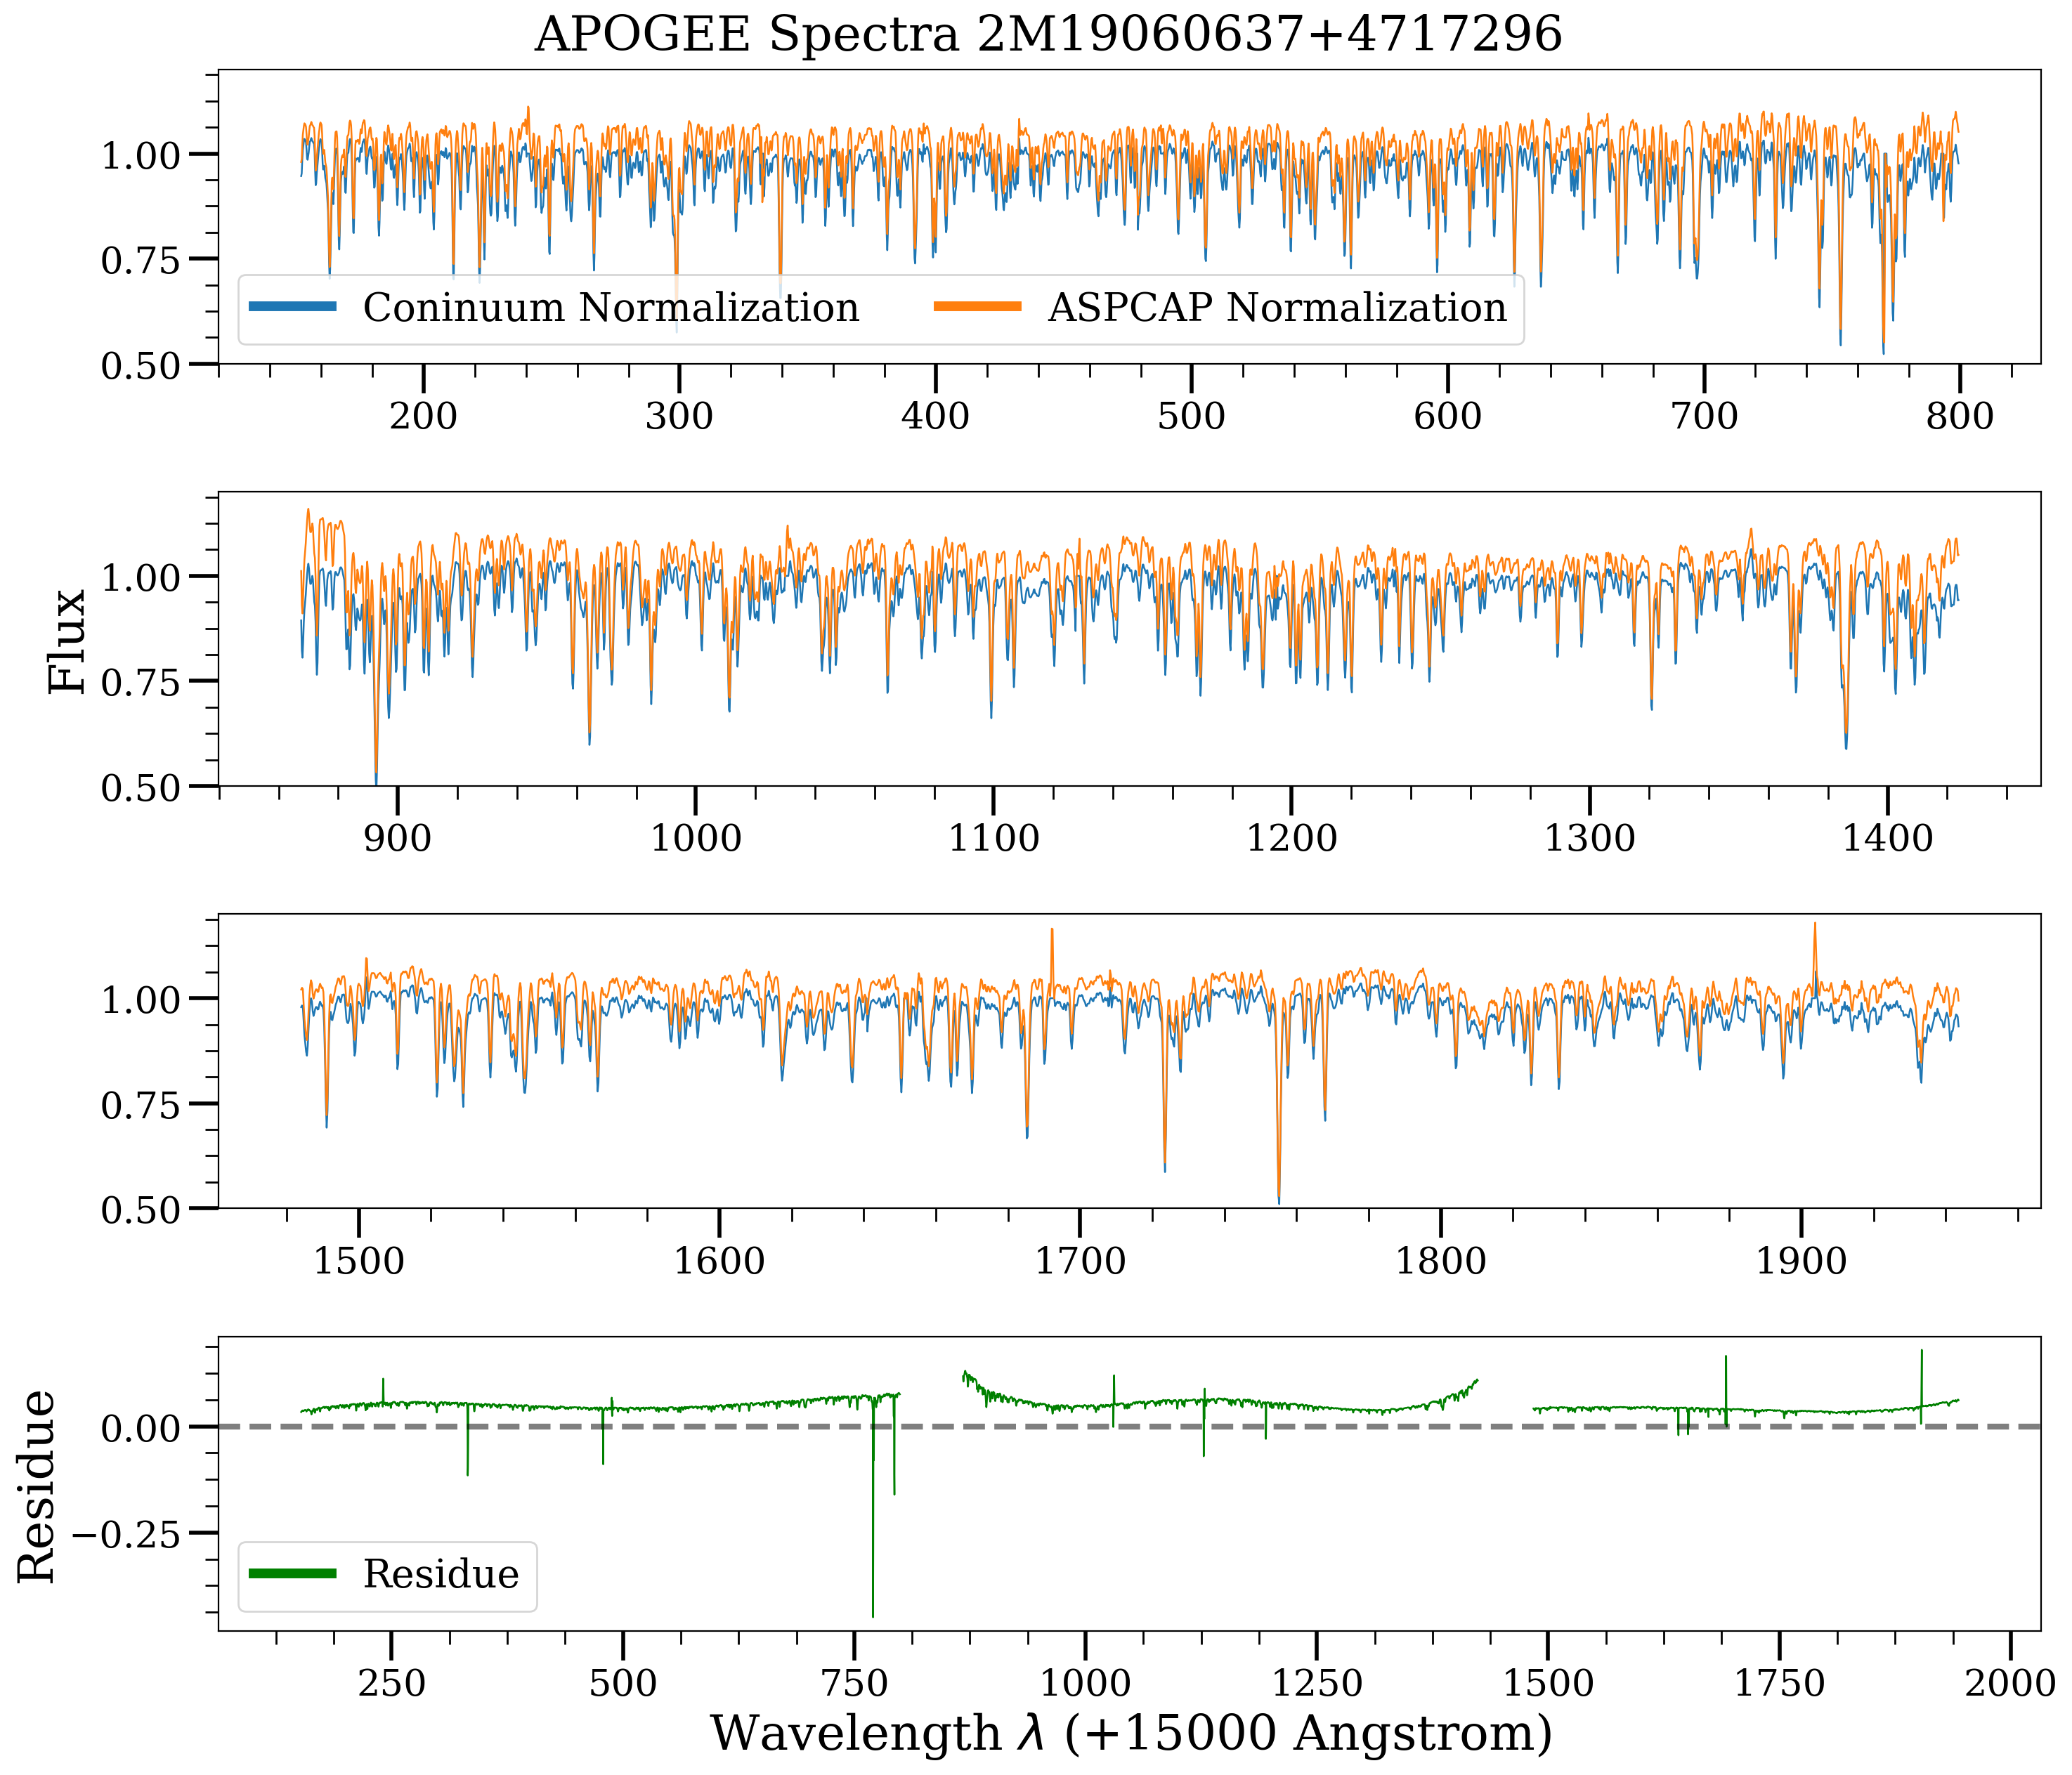

In [3]:
%matplotlib inline
from astroNN.apogee import visit_spectra, combined_spectra, gap_delete, apogee_continuum, bitmask_boolean
import matplotlib.ticker as ticker
from astroNN.apogee.chips import wavelength_solution, chips_split
from astropy.io import fits 
import numpy as np
import pylab as plt

plt.rc('font',**{'family': 'serif', 'weight':'medium', 'size':20})

target_bit = [0, 1, 2, 3, 4, 5, 6, 7, 12]
apstar_file = fits.open(visit_spectra(dr=14, location=4405, apogee="2M19060637+4717296", verbose=0))

# read the raw spectra from apstar
_spec = np.vstack((apstar_file[1].data, apstar_file[1].data))
_spec_err = np.vstack((apstar_file[2].data, apstar_file[2].data))
_spec_mask = np.vstack((apstar_file[3].data, apstar_file[3].data))

# delete gaps, normalize spectra and set target_bits in bitmask to 0
_spec = gap_delete(_spec, dr=14)
_spec_err = gap_delete(_spec_err, dr=14)
_spec_mask = gap_delete(_spec_mask, dr=14)
_normspec, _spec_err = apogee_continuum(_spec, _spec_err, bitmask=_spec_mask, target_bit=target_bit, dr=14, mask_value=1.)

spec = gap_delete(fits.getdata(combined_spectra(dr=14, location=4405, apogee="2M19060637+4717296", verbose=0)), dr=14)

lambda_blue, lambda_green, lambda_red = wavelength_solution(dr=14)

lambda_blue -= 15000
lambda_green -= 15000
lambda_red -= 15000

fig = plt.figure(figsize=(15, 13), dpi=200)
blue, green, red = chips_split(_normspec[0], dr=14)
blue, green, red = blue[0], green[0], red[0]

aspcap_blue, aspcap_green, aspcap_red = chips_split(spec[0], dr=14)
aspcap_blue, aspcap_green, aspcap_red = aspcap_blue[0], aspcap_green[0], aspcap_red[0]

fig.suptitle('APOGEE Spectra 2M19060637+4717296', fontsize=25)
ax1 = fig.add_subplot(411)
ax1.plot(lambda_blue, blue, linewidth=0.9,rasterized=True, label='Coninuum Normalization')
ax1.plot(lambda_blue, aspcap_blue, linewidth=0.9,rasterized=True, label='ASPCAP Normalization')
ax1.set_ylim((0.5, 1.2))
ax2 = fig.add_subplot(412)
ax2.set_ylabel('Flux', fontsize=25)
ax2.plot(lambda_green, green, linewidth=0.9,rasterized=True, label='astroNN')
ax2.plot(lambda_green, aspcap_green, linewidth=0.9,rasterized=True, label='ASPCAP')
ax2.set_ylim((0.5, 1.2))
ax3 = fig.add_subplot(413)
ax3.plot(lambda_red, red, linewidth=0.9,rasterized=True, label='astroNN')
ax3.plot(lambda_red, aspcap_red, linewidth=0.9,rasterized=True, label='ASPCAP')
ax3.set_ylim((0.5, 1.2))

ax4 = fig.add_subplot(414)
ax4.plot(lambda_blue, aspcap_blue-blue, linewidth=0.9, c='green',rasterized=True, label='Residue')
ax4.plot(lambda_green, aspcap_green-green,rasterized=True, linewidth=0.9, c='green')
ax4.plot(lambda_red, aspcap_red-red, linewidth=0.9,rasterized=True, c='green')
ax4.set_xlabel(r'Wavelength $\lambda$ (+15000 Angstrom)', fontsize=25)
ax4.set_ylabel('Residue', fontsize=25)
# ax4.set_title('Residue', fontsize=25)
ax4.axhline(0, ls='--', c='k', lw=3., alpha=0.5)

ax1.tick_params(labelsize=19, width=2, length=15, which='major')
ax1.tick_params(width=1, length=7, which='minor')
ax2.tick_params(labelsize=19, width=2, length=15, which='major')
ax2.tick_params(width=1, length=7, which='minor')
ax3.tick_params(labelsize=19, width=2, length=15, which='major')
ax3.tick_params(width=1, length=7, which='minor')
ax4.tick_params(labelsize=19, width=2, length=15, which='major')
ax4.tick_params(width=1, length=7, which='minor')
leg = ax1.legend(loc='best', fontsize=20, ncol=2)
leg2 = ax4.legend(loc='best', fontsize=20)

for legobj in leg.legendHandles:
    legobj.set_linewidth(5.0)

for legobj in leg2.legendHandles:
    legobj.set_linewidth(5.0)
    
tick_spacing = 150
# ax1.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
# ax2.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing / 1.5))
# ax3.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing / 1.7))
ax1.minorticks_on()
ax2.minorticks_on()
ax3.minorticks_on()
ax4.minorticks_on()
plt.tight_layout(rect=[0, 0.00, 1, 0.98])
plt.savefig('normalization_aspcap.pdf')